# Parte 1: Detección de movimiento con diferencia de frames y modelo de fondo 

In [1]:
# Importamos librerías importantes
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
# Creamos una lista que guardará las imágenes correspondientes a la primera secuencia 
path = glob.glob("Lab-Mov//seq1//seq1//*.jpg")
seq1 = [cv2.imread(file,0) for file in path]

In [3]:
# Creamos una lista que guardará las imágenes correspondientes a la segunda secuencia 
path2 = glob.glob("Lab-Mov//seq2//seq2//*.jpg")
seq2 = [cv2.imread(file,0) for file in path2]

In [4]:
# Creamos una lista que guardará las imágenes correspondientes a la tercera secuencia 
path3 = glob.glob("Lab-Mov//seq3//seq3//*.jpg")
seq3 = [cv2.imread(file,0) for file in path3]

In [8]:
# Creamos una lista que guardará las imágenes correspondientes al fondo
path7 = glob.glob("Lab-Mov//fondo//fondo//*.jpg")
fondo = [cv2.imread(file,0) for file in path7]

(-0.5, 1279.5, 799.5, -0.5)

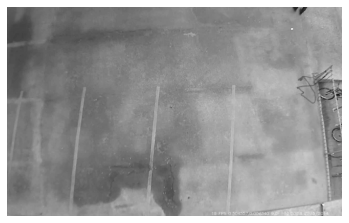

In [9]:
# Mostramos una imagen de prueba en escala de grises
a = seq1[0] 
plt.imshow(a,cmap='gray')
plt.axis('off')

(-0.5, 1279.5, 799.5, -0.5)

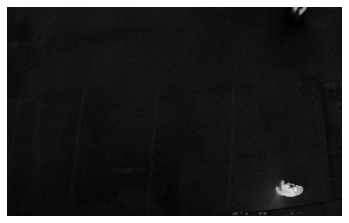

In [10]:
# Probamos la resta de dos imágenes para comprobar la detección de movimiento
d=abs(seq1[300].astype(float) - seq1[0].astype(float))
plt.imshow(d,cmap='gray')
plt.axis('off')

(-0.5, 1279.5, 799.5, -0.5)

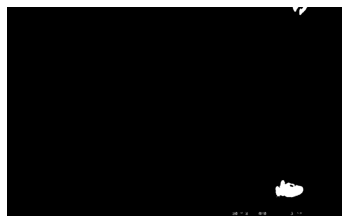

In [11]:
d.shape
d=abs(seq1[300].astype(float) - seq1[0].astype(float))
threshold = 50
for j in range(d.shape[1]):
    for i in range(d.shape[0]):
        if d[i][j]>threshold:
            d[i][j] = 255
        else:
            d[i][j] = 0
plt.imshow(d,cmap='gray')
plt.axis('off')

## Detección de movimiento por diferencia de cuadros

In [12]:
# Esta función calcula la diferencia de cuadros de toda la secuencia ingresada tomando un valor umbral definido por el usuario
def Frame_Diff2(seq,umbral=50):
    Diff = []
    for i in range(1,len(seq)):
        Diff.append(abs(seq[i].astype(float) - seq[i-1].astype(float))) # Valor absoluto de la resta
    for i in range(len(Diff)):
        Diff[i] = cv2.inRange(Diff[i], umbral, 255)
    return Diff

In [13]:
FDs1 = Frame_Diff2(seq1)

Text(0.5, 1.0, 'desviación pixel a pixel del fondo')

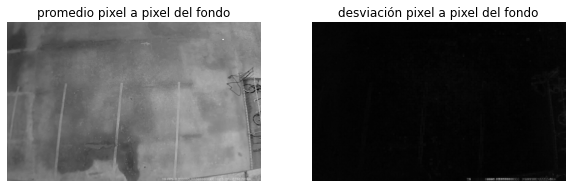

In [14]:
# Calculamos el promedio y desviación estándar del fondo (ámbos pixel a pixel)
mean_fondo = np.mean(fondo, axis=0)
std_fondo = np.std(fondo, axis=0)
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1) 
plt.imshow(mean_fondo,cmap='gray')
plt.axis('off')
plt.title('promedio pixel a pixel del fondo')

fig.add_subplot(rows, columns, 2) 
plt.imshow(std_fondo,cmap='gray')
plt.axis('off')
plt.title('desviación pixel a pixel del fondo')

In [15]:
# Entregamos la matriz 1 correspondiente al promedio del fondo:
print(mean_fondo.shape)

(800, 1280)


In [16]:
# Entregamos la matriz 2 correspondiente a la desviación del fondo:
print(std_fondo.shape)

(800, 1280)


In [17]:
def Av_Back2(fondo, threshold, seq):
    X = np.mean(fondo, axis=0) # Promedio
    D = np.std(fondo, axis=0) # Desviación
    L1 = X + threshold * (D + 1) # Límite 1
    L2 = X - threshold * (D + 1) # Límite 2
    Back = [] # Lista que guarda el resultado
    M = []
    for k in range(len(seq)):
        mask_bool = np.logical_or(seq[k] > L1, seq[k] < L2)
        M.append(mask_bool)
    for k in range(len(M)):
        M[k] = np.array(M[k])*255
    return M

In [18]:
ABs1 = Av_Back2(fondo, 20, seq1)

(-0.5, 1279.5, 799.5, -0.5)

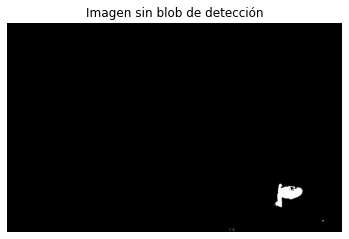

In [19]:
plt.imshow(ABs1[312],cmap='gray')
plt.title('Imagen sin blob de detección')
plt.axis('off')

# Box detection

In [20]:
def draw_box(img,line = 4,title='imagen',factor_umbral = 2,figsize=(8,16)):
    M = img
    # Histogramas
    Hist_cols = np.sum(M,axis=0)
    Hist_rows = np.sum(M,axis=1)
    x = []
    y = []

    for i in range(len(Hist_cols)):
        if Hist_cols[i] > factor_umbral*np.mean(Hist_cols):
            x.append(i)
        else:
            pass
    for j in range(len(Hist_rows)):
        if Hist_rows[j] > factor_umbral*np.mean(Hist_rows):
            y.append(j)
        else:
            pass
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)

    M = M.astype(np.uint8)
    M_rgb = cv2.merge([M,M,M])
    
    # dibujamos el box
    cv2.rectangle(M_rgb,(minx,miny),(maxx,maxy),(153, 102, 204),4)

    plt.figure(figsize=(8,16))
    plt.imshow(M_rgb)
    plt.title(title)
    plt.axis('off')
    

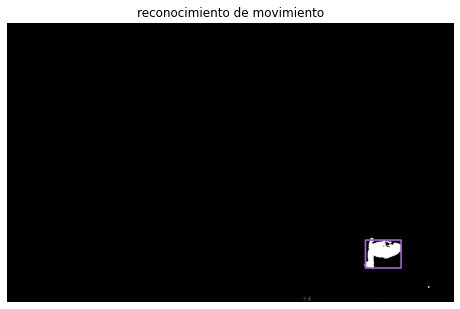

In [21]:
draw_box(ABs1[312],title='reconocimiento de movimiento')

# Parte 2: Tracking simple de personas 

(-0.5, 1279.5, 799.5, -0.5)

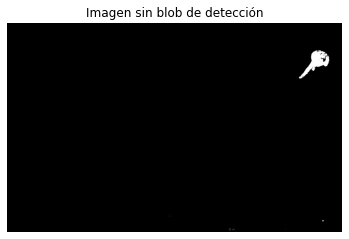

In [22]:
# usemos una secuencia concida para determinar los parametros A,B,C,D
#que seran utilizados para realziar un tracking simple

# probemos usando desde el 180 hasta el 250 de seq1
plt.imshow(ABs1[100],cmap='gray')
plt.title('Imagen sin blob de detección')
plt.axis('off')

## seccionamos una secuencia para determinar los parametros

In [23]:
seq_train = ABs1[180:250]

In [24]:
#Extraemos los datos de los cuadros correspondientes a la secuencia concida
minx_train,maxx_train = [], []
miny_train,maxy_train = [], []

for M in seq_train:

    # Histogramas
    Hist_cols = np.sum(M,axis=0)
    Hist_rows = np.sum(M,axis=1)
    x = []
    y = []

    for i in range(len(Hist_cols)):
        if Hist_cols[i] > 2*np.mean(Hist_cols):
            x.append(i)
        else:
            pass
    for j in range(len(Hist_rows)):
        if Hist_rows[j] > 2*np.mean(Hist_rows):
            y.append(j)
        else:
            pass
    minx_train.append(np.min(x))
    maxx_train.append(np.max(x))
    miny_train.append(np.min(y))
    maxy_train.append(np.max(y))

In [25]:
#Creamos los inputs y outputs correspondientes
inputs1 = []
inputs2 = []
outputs = []
for i in range(1,len(minx_train)-1):
    inputs1.append([minx_train[i-1],maxx_train[i-1],miny_train[i-1],maxy_train[i-1]])
    inputs2.append([minx_train[i],maxx_train[i],miny_train[i],maxy_train[i]])
    outputs.append([minx_train[i+1],maxx_train[i+1],miny_train[i+1],maxy_train[i+1]])

In [26]:
inputs1[0],inputs2[0],outputs[0]

([1058, 1170, 351, 439], [1058, 1169, 353, 439], [1058, 1167, 357, 439])

In [27]:
"""
h3 = h2 + A*(h2-h1) -> A = (h3-h2)/(h2-h1) minx
w3 = w2 + B*(w2-w1) -> B = (w3-w2)/(w2-w1) maxx
x3 = x2 + C*(x2-x1) -> C = (x3-x2)/(x2-x1) miny
y3 = y2 + D*(y2-y1) -> D = (y3-y2)/(y2-y1) maxy
"""
A_array = []
B_array = []
C_array = []
D_array = []
for L1,L2,L3 in zip(inputs1,inputs2,outputs):
    h1,h2,h3 = L1[0],L2[0],L3[0]
    w1,w2,w3 = L1[1],L2[1],L3[1]
    x1,x2,x3 = L1[2],L2[2],L3[2]
    y1,y2,y3 = L1[3],L2[3],L3[3]
    if h2-h1 != 0:
        A_array.append((h3-h2)/(h2-h1))
    if w2-w1 != 0:
        B_array.append((w3-w2)/(w2-w1))
    if x2-x1 != 0:
        C_array.append((x3-x2)/(x2-x1))
    if y2-y1:
        D_array.append((y3-y2)/(y2-y1))
        
# Estimamos los parametros usando el promedio de los parametros encontrados
A = np.mean(A_array)
B = np.mean(B_array)
C = np.mean(C_array)
D = np.mean(D_array)
print("A:",A,"B:",B,"C:",C,"D:",D)

A: 0.5681818181818182 B: 0.6944444444444444 C: 1.2911616161616162 D: 0.8825640942182295


In [28]:
# L_min% y L_max% tienen que tener los dos valores min% y max% respectivamente anteriores
def pred_box(img,L_minx,L_maxx,L_miny,L_maxy):
    #-----------------------------------------------------------------------------
    # usando el modelo de tracking simple
    M=img

    minx = int(L_minx[-1] + A*(L_minx[-1]-L_minx[-2]))
    maxx = int(L_maxx[-1] + B*(L_maxx[-1]-L_maxx[-2]))
    miny = int(L_miny[-1] + C*(L_miny[-1]-L_miny[-2]))
    maxy = int(L_maxy[-1] + D*(L_maxy[-1]-L_maxy[-2]))

    M = M.astype(np.uint8)
    M_rgb = cv2.merge([M,M,M])
    cv2.rectangle(M_rgb,(minx,miny),(maxx,maxy),(200, 50, 50),4)

    plt.figure(figsize=(16,18))
    plt.imshow(M_rgb)
    plt.title('Imagen')
    plt.axis('off')
    return (minx,miny),(maxx,maxy)

# TEST

(-0.5, 1279.5, 799.5, -0.5)

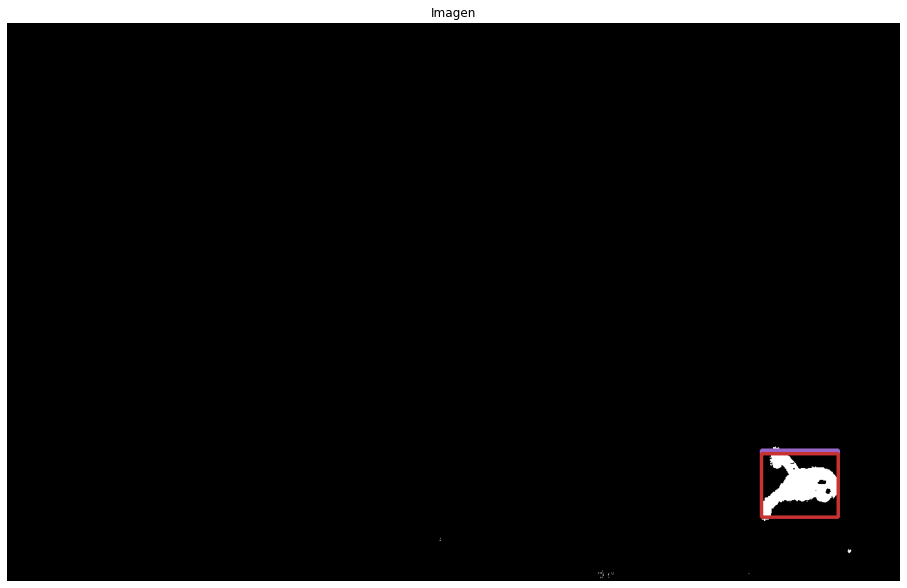

In [29]:

#-----------------------------------------------------------------------------
# usando el modelo de tracking simple

minx = int(minx_train[-1] + A*(minx_train[-1]-minx_train[-2]))
maxx = int(maxx_train[-1] + B*(maxx_train[-1]-maxx_train[-2]))
miny = int(miny_train[-1] + C*(miny_train[-1]-miny_train[-2]))
maxy = int(maxy_train[-1] + D*(maxy_train[-1]-maxy_train[-2]))

M = seq_train[-1]
M = M.astype(np.uint8)
M_rgb = cv2.merge([M,M,M])
cv2.rectangle(M_rgb,(minx_train[-1],miny_train[-1]),(maxx_train[-1],maxy_train[-1]),(153, 102, 204),4)
cv2.rectangle(M_rgb,(minx,miny),(maxx,maxy),(200, 50, 50),4)

plt.figure(figsize=(16,18))
plt.imshow(M_rgb)
plt.title('Imagen')
plt.axis('off')

In [30]:
#----------------------------------------------------------------------------------------

In [37]:
# Creamos una lista que guardará las imágenes correspondientes a la primera secuencia 
path = glob.glob("Lab-Mov//seq4//seq4//*.bmp")
path.sort(key=lambda x: int((x.split(".")[0].split('\\')[1].split("-")[1]))) # reordena los frames

seq4 = [cv2.imread(file,0) for file in path]


# Creamos una lista que guardará las imágenes correspondientes a la primera secuencia 
path = glob.glob("Lab-Mov//seq5//seq5//*.bmp")
path.sort(key=lambda x: int((x.split(".")[0].split('\\')[1].split("-")[1]))) # reordena los frames

seq5 = [cv2.imread(file,0) for file in path]

# Creamos una lista que guardará las imágenes correspondientes a la primera secuencia 
path = glob.glob("Lab-Mov//seq6//seq6//*.bmp")
path.sort(key=lambda x: int((x.split(".")[0].split('\\')[1].split("-")[1]))) # reordena los frames

seq6 = [cv2.imread(file,0) for file in path]

(-0.5, 351.5, 287.5, -0.5)

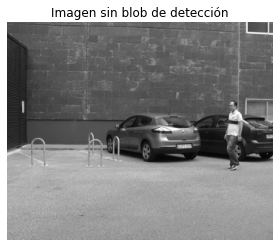

In [38]:
plt.imshow(cv2.cvtColor(seq4[200], cv2.COLOR_BGR2RGB),cmap='gray')
plt.title('Imagen sin blob de detección')
plt.axis('off')

In [39]:
FDs4 = Frame_Diff2(seq4,60)
len(FDs4)

424

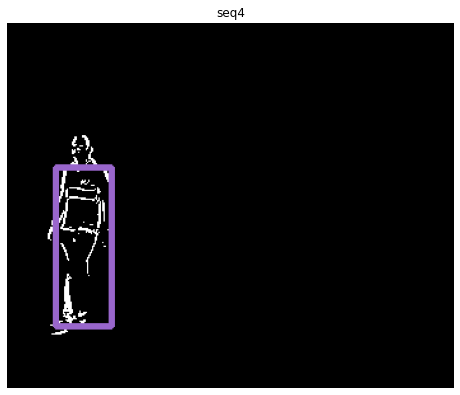

In [40]:
draw_box(FDs4[320],title='seq4',factor_umbral=4)

In [41]:
FDs5 = Frame_Diff2(seq5,60)
len(FDs5)

299

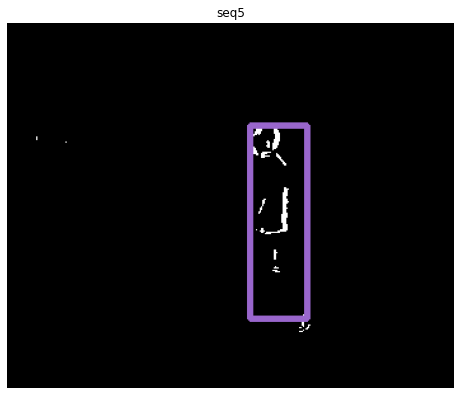

In [51]:
draw_box(FDs5[180],title='seq5',factor_umbral=3)

In [54]:
FDs6 = Frame_Diff2(seq6,80)
len(FDs5)

299

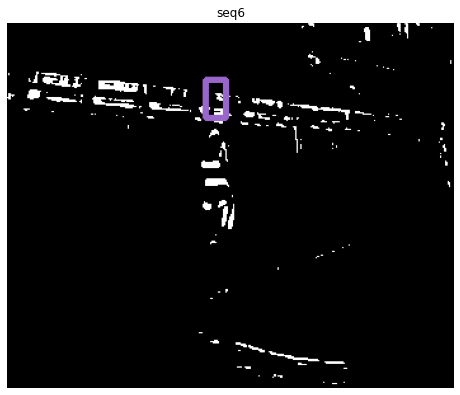

In [55]:
draw_box(FDs6[180],title='seq6',factor_umbral=3)

In [35]:
seq_test = seq4[230:320]